In [2]:
# %autoreload
import numpy as np
import matplotlib.pyplot as plt

from evoscape.module_helper_functions import modules_from_txt, rotate_landscape
from evoscape.landscapes import CellDiff_Dataset_Landscape
import evoscape.landscape_visuals as vis
from evoscape.morphogen_regimes import mr_piecewise, mr_current_regime
from matplotlib.colors import ListedColormap, BoundaryNorm, CenteredNorm, Normalize

from matplotlib import style
style.use('default')

%load_ext autoreload

In [3]:
plt.rcParams.update({'figure.dpi': 200})
plt.rcParams.update({'font.size': 15})
plt.rcParams['axes.grid'] = False

save_dir = '../frames/'

In [4]:
data_dir = '../alfyn_results_stage2/saved_files_8/CellDiff_Dataset_Landscape/'
file_name = data_dir + 'optimization_log.csv'

# log = pd.read_csv(file_name, sep='\t', names=['Timecode', 'Init timecode', 'Fitness'], skiprows=1)
log = np.genfromtxt(file_name, delimiter='\t', skip_header=1, names=['Timecode', 'Init_timecode', 'Fitness'], dtype=None, encoding='utf-8')
print(log.shape)

fitness_threshold = -0.5505
n_landscapes = np.sum(log['Fitness'] > fitness_threshold)
print(n_landscapes)
timecodes = log['Timecode'][log['Fitness'] > fitness_threshold]


def landscape_from_timecode(timecode, data_dir, gen, landscape_pars):
    filename = data_dir + timecode + '/' + timecode + '_module_list_' + str(gen) + '.txt'
    with open(filename, 'r') as f:
        module_list = modules_from_txt(filename)
    landscape = CellDiff_Dataset_Landscape(module_list, A0=landscape_pars['A0'], regime=mr_piecewise, n_regimes=5)
    return landscape

landscape_pars = {
    'A0': 0.005,
}
gen = 300

(241,)
60


In [9]:
def rotate_landscape(landscape, origin=0, direction=2, left=None, right=None, bottom=None):
    module_coords = np.zeros((len(landscape.module_list), 2))
    for i, module in enumerate(landscape.module_list):
        module_coords[i, :] = module.x, module.y
    x0 = np.zeros((1, 2))
    x0 -= module_coords[origin]
    module_coords = module_coords - module_coords[origin]

    norm_coords = (module_coords.T/np.linalg.norm(module_coords, axis=1).T).T
    x, y = np.sum(norm_coords[direction, 0]), np.sum(norm_coords[direction, 1])

    d = np.linalg.norm((x, y))
    R = np.array([[x, y], [-y, x]])/d
    x0 = (R @ x0.T).T
    module_coords = (R @ module_coords.T).T

    if bottom is not None:
        if module_coords[bottom, 1] > 0:    # flip the y-axis if needed
            module_coords[:, 1] *= -1.
            x0[0, 1] *= -1.
    if left is not None:
        if module_coords[left, 0] > 0:     # flip the x-axis if needed
            module_coords[:, 0] *= -1.
            x0[0, 0] *= -1.
    if right is not None:
        if module_coords[right, 0] < 0:     # flip the x-axis if needed
            module_coords[:, 0] *= -1.
            x0[0, 0] *= -1.
    for i, module in enumerate(landscape.module_list):
        module.x, module.y = module_coords[i, :]
    landscape.x0 = x0[0]

    return landscape



/var/folders/yn/r99j3qy962lg5cwmzc1dpqg40000gn/T/ipykernel_31876/3123094523.py:9: RuntimeWarning: invalid value encountered in divide
  norm_coords = (module_coords.T/np.linalg.norm(module_coords, axis=1).T).T
/Users/victoria/Code/evoscape/src/evoscape/landscapes/landscape_class.py:272: RuntimeWarning: divide by zero encountered in divide
  -np.sum((coordinate.T - np.array((module.x, module.y))) ** 2, axis=1) / 2. / st ** 2) / st ** 2
/Users/victoria/Code/evoscape/src/evoscape/landscapes/landscape_class.py:271: RuntimeWarning: invalid value encountered in divide
  prob[:, i] = np.exp(
/Users/victoria/Code/evoscape/src/evoscape/landscapes/landscape_class.py:61: RuntimeWarning: divide by zero encountered in divide
  weight = np.exp(-0.5 * (r / sig) ** 2)


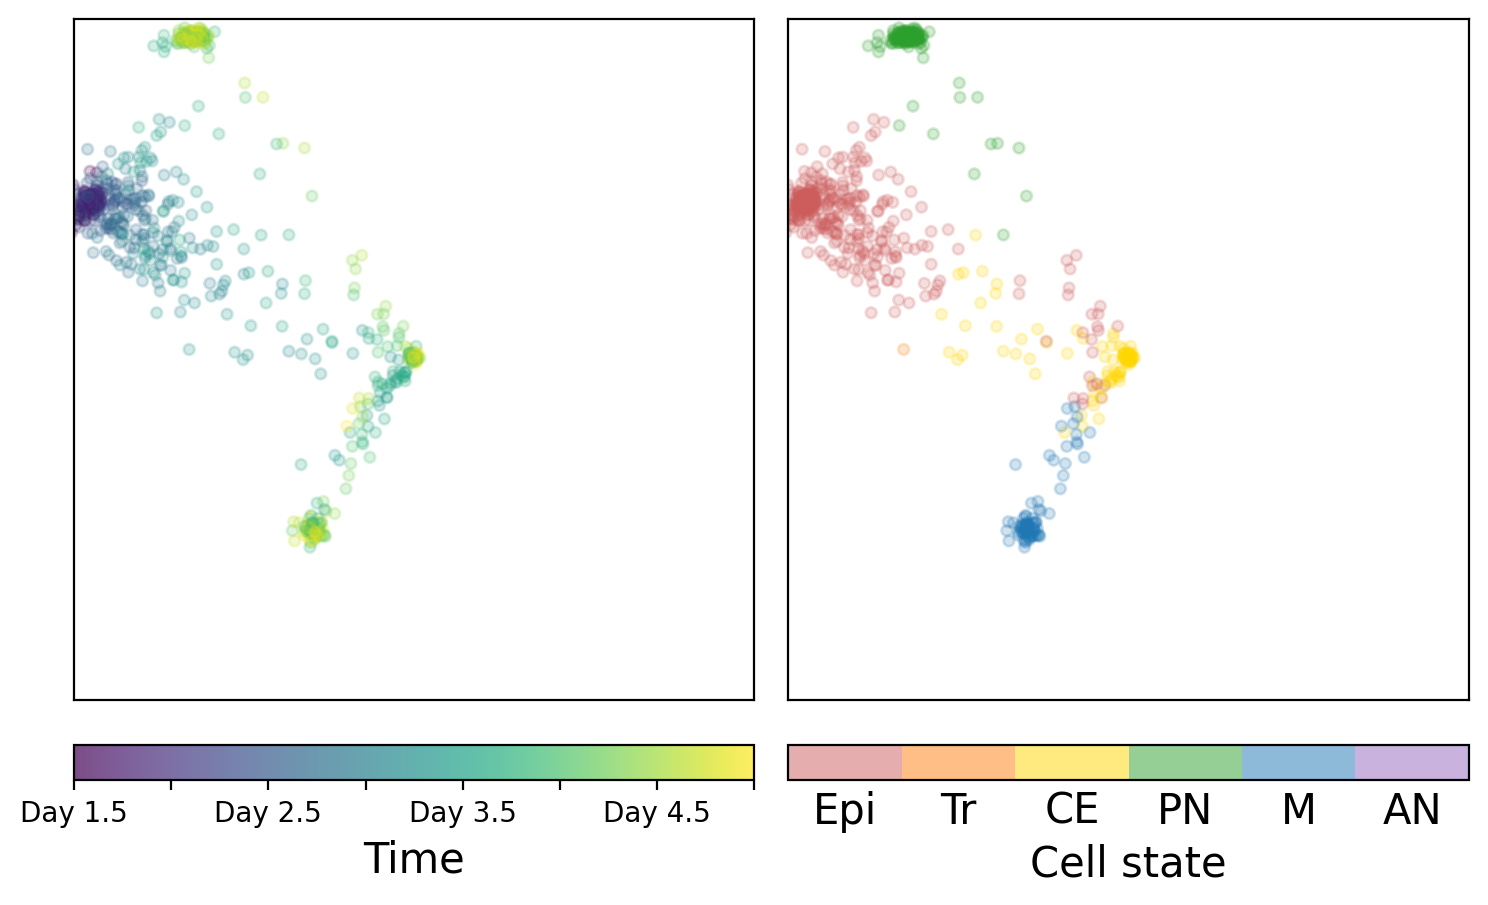

In [14]:
%autoreload

L = 5.
npoints = 401
q = np.linspace(-L, L, npoints)
xx, yy = np.meshgrid(q,q, indexing = 'xy')

colors = ('indianred', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'tab:purple')
cmap_state = ListedColormap(colors)
norm_state = BoundaryNorm(np.arange(len(colors)+1) - 0.5, cmap_state.N)
state_names = ('Epi', 'Tr', 'CE', 'PN', 'M', 'AN')

noise = 0.2
ndt = 50
nt = 15
ncells = 300


init_state = 2

origin = 2
direction = (3,4)
right = None
bottom = 4
left = 0

delta=2.
# morphogen_times = (delta*1, delta*3, delta*7, delta*7)  # exp 5
morphogen_times = (delta*1, delta*3, delta*3, delta*3)  # exp 2: Chir 2-3

time_pars = (0, delta*7, 25)

# ______________

ind =  51 # 49, 58   # Select landscape sample

landscape = landscape_from_timecode(timecodes[ind], data_dir, gen, landscape_pars)
landscape = rotate_landscape(landscape, origin=origin, direction=direction, left=left, right=right, bottom=bottom)
landscape.morphogen_times = morphogen_times


time_pars = (0, delta*5, 25)
landscape.init_cells(30, 0, noise)
fig = vis.get_and_plot_traj(landscape, *time_pars, 4, noise, ndt = ndt, s=15, state_names=state_names,
                            t_ticks = (0, delta*5, 8),
                            t_names=('Day 1.5', '', 'Day 2.5', '', 'Day 3.5', '', 'Day 4.5', ''),)
                            # t_names=('', 'Day 2', '', 'Day 3', '', 'Day 4', '', 'Day 5'),)
plt.show()

In [15]:
# %autoreload

n_frames = 300
time_pars = (0, delta*7, n_frames)
# morphogen_times = (delta*1, delta*3, delta*7, delta*7)  # exp 5
morphogen_times = (delta*1, delta*3, delta*3, delta*3)  # exp 2: Chir 2-3

labels = ('FGF', 'FGF+CHIR', 'CHIR', 'CHIR+end.FGF', 'end.FGF')
n_cells = 50
noise = 0.2

for ind in range(60): # 49, 58   # Select landscape samples

    landscape = landscape_from_timecode(timecodes[ind], data_dir, gen, landscape_pars)
    landscape = rotate_landscape(landscape, origin=origin, direction=direction, left=left, right=right, bottom=bottom)
    landscape.morphogen_times = morphogen_times
    vis.make_movie_discrete(landscape, xx, yy, labels, time_pars, n_cells, noise, save_dir=save_dir, filename=f"exp2_{ind}.gif")   # file name!


/var/folders/yn/r99j3qy962lg5cwmzc1dpqg40000gn/T/ipykernel_31876/3123094523.py:9: RuntimeWarning: invalid value encountered in divide
  norm_coords = (module_coords.T/np.linalg.norm(module_coords, axis=1).T).T
/Users/victoria/Code/evoscape/src/evoscape/landscapes/landscape_class.py:61: RuntimeWarning: divide by zero encountered in divide
  weight = np.exp(-0.5 * (r / sig) ** 2)
/Users/victoria/Code/evoscape/src/evoscape/landscapes/landscape_class.py:61: RuntimeWarning: invalid value encountered in divide
  weight = np.exp(-0.5 * (r / sig) ** 2)
/Users/victoria/Code/evoscape/src/evoscape/landscapes/landscape_class.py:272: RuntimeWarning: divide by zero encountered in divide
  -np.sum((coordinate.T - np.array((module.x, module.y))) ** 2, axis=1) / 2. / st ** 2) / st ** 2
/Users/victoria/Code/evoscape/src/evoscape/landscapes/landscape_class.py:271: RuntimeWarning: invalid value encountered in divide
  prob[:, i] = np.exp(


Movie saved to ../frames/exp2_0.gif
Movie saved to ../frames/exp2_1.gif
Movie saved to ../frames/exp2_2.gif
Movie saved to ../frames/exp2_3.gif
Movie saved to ../frames/exp2_4.gif
Movie saved to ../frames/exp2_5.gif
Movie saved to ../frames/exp2_6.gif
Movie saved to ../frames/exp2_7.gif
Movie saved to ../frames/exp2_8.gif
Movie saved to ../frames/exp2_9.gif
Movie saved to ../frames/exp2_10.gif
Movie saved to ../frames/exp2_11.gif
Movie saved to ../frames/exp2_12.gif
Movie saved to ../frames/exp2_13.gif
Movie saved to ../frames/exp2_14.gif
Movie saved to ../frames/exp2_15.gif
Movie saved to ../frames/exp2_16.gif
Movie saved to ../frames/exp2_17.gif
Movie saved to ../frames/exp2_18.gif
Movie saved to ../frames/exp2_19.gif
Movie saved to ../frames/exp2_20.gif
Movie saved to ../frames/exp2_21.gif
Movie saved to ../frames/exp2_22.gif
Movie saved to ../frames/exp2_23.gif
Movie saved to ../frames/exp2_24.gif
Movie saved to ../frames/exp2_25.gif
Movie saved to ../frames/exp2_26.gif
Movie saved

In [104]:
mr_current_regime(12., *morphogen_times)

array(2)